<br>
<br>

![iteso](https://upload.wikimedia.org/wikipedia/en/5/5f/Western_Institute_of_Technology_and_Higher_Education_logo.png)

##  InstitutoTecnológico y de Estudios Superiores de Occidente ###
##  Maestría Ciencia de Datos  ###
##  Ingeniería de Características ###
##  Práctica 2 Discretización y transformación  ###

<br>
<br>

* * *

Estudiante: Daniel Nuño <br>
Profesor: Dr. Carlos Augusto Arellano Muro <br>
Fecha entrega: 7 de abril, 2022 <br>

* * *

<br>
<br>

<div style="page-break-after: always;"></div>

El objetivo de esta práctica es obtener un modelo del comportamiento de un sistema de tanques de almacenamiento.

En esta práctica se comparan diferentes métodos en el tratamiento de datos para obtener mejores resultados en el entrenamiento de un futuro modelo con redes neuronales.

### Instrucciones:
#### 1. Leer  el  archivo  de  Excel  donde  se  muestran  fechas  y  los  niveles  de  4  tanques, mostrar además, el histograma de los datos.

In [331]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox

data = pd.read_excel('Datos presas.xlsx')
data.head()
print(data.shape)

(3287, 5)


array([[<AxesSubplot:title={'center':'Nivel 1'}>,
        <AxesSubplot:title={'center':'Nivel 2'}>],
       [<AxesSubplot:title={'center':'Nivel 3'}>,
        <AxesSubplot:title={'center':'Nivel 4'}>]], dtype=object)

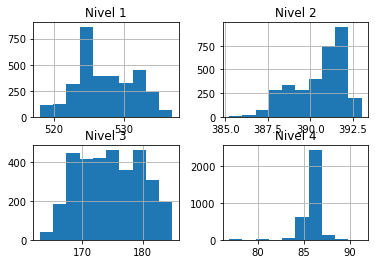

In [332]:
data[['Nivel 1', 'Nivel 2', 'Nivel 3', 'Nivel 4']].hist()

De cada tanque se puede observar:
- nivel 1: distribución sesgada positivamente y bimodal.
- nivel 2: distribución sesgada negativa y ligeramente de curtosis mesocúrtica.
- nivel 3: distribución mayor mente uniforme.
- nivel 4: distribución leptocúrtica muy centrada entre el 85 y 86 y sesgada negativamente.

#### 2. Transformar mediante boxcox  cada  variable  y  comparar  antes  y  después  de  la transformación a través del histograma.

lambdas
Nivel 1    0.727039
Nivel 2    2.320144
Nivel 3    0.797279
Nivel 4    3.154639
Name: 1, dtype: object


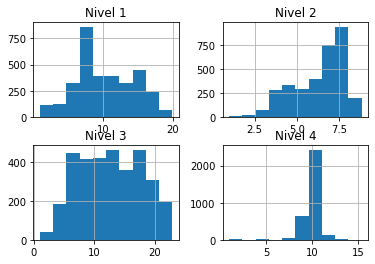

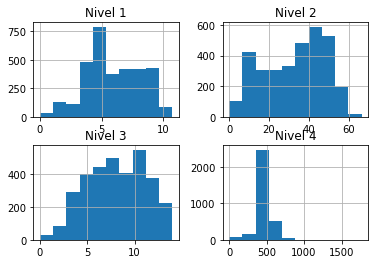

In [333]:
data_en_uno = data[['Nivel 1', 'Nivel 2', 'Nivel 3', 'Nivel 4']].apply(lambda x: x - x.min() + 1, axis=0)
data_en_uno.hist()

box_cox = data_en_uno.apply(lambda x: boxcox(x), axis=0)
lmdb = box_cox.iloc[1,:]
box_cox = box_cox.iloc[0,:]
df_box_cox = pd.DataFrame()
df_box_cox['Nivel 1'] = box_cox[0]
df_box_cox['Nivel 2'] = box_cox[1]
df_box_cox['Nivel 3'] = box_cox[2]
df_box_cox['Nivel 4'] = box_cox[3]
df_box_cox.hist()
print('lambdas')
print(lmdb)

#### 3. Explique, ¿por qué el conjunto completo de los datos transformados no se asemeja a una distribución normal?
Box Cox es una transformación utilizada para estabilizar la varianza y hacer los datos más semejantes a las normales incluyendo el sesgo, pero no es garantía de normalidad. El método no revisa la normalidad, el método checo por la menor desviación estándar.

Esencialmente usa lambda exponencialmente y la mejor lambda es cual tenga mejor likelihood de normalidad en el conjunto con todos los datos.

En distribuciones como tanque 3 cambia de ser uniforme a ser más normal. Distribuciones como el tanque 4 hace que valores atípicos empujen con más fuerza la distribución y obtengas algunos valores muy altos. De hecho, la distribución 4 de boxcox parece un reflejo de la original.

#### 4. Discretizar cada variable (sin transformar) por año.

In [334]:
data['años'] = data['Fecha'].dt.year

#### 5. Transformar cada variable discretizada usando boxcox.
Igualmente, antes de transformar vamos a desplazar a 1.

In [335]:
for tanque in ['Nivel 1', 'Nivel 2', 'Nivel 3', 'Nivel 4']:
    x = np.array([])
    for year in data['años'].unique():
        d = data.groupby('años')[tanque].get_group(year).to_numpy()
        d = d - d.min() + 1
        bc, _ = boxcox(d)
        x = np.concatenate((x, bc))
    data[(tanque + '_years_bc')] = x


#### 6. Discretizar cada variable (sin transformar) usando k-means. Proponga el valor de k y justifíquelo.
Voy usar **k** como 9 porque quisiera comparar también con la discretización por año y notar como el algoritmo decide la separación.

In [337]:
from sklearn.preprocessing import KBinsDiscretizer
K = 9
disc = KBinsDiscretizer(n_bins=K ,encode='ordinal', strategy='kmeans')

kbmeans_df = pd.DataFrame()
for i in ['Nivel 1', 'Nivel 2', 'Nivel 3', 'Nivel 4']:
    x = data[[i]]
    kbmeans = disc.fit_transform(x)
    data[(i + '_kmeans')] = kbmeans.astype('float')
    mean = data.groupby(i + '_kmeans')[i].mean()
    mean = mean.to_numpy()
    kbmeans_df[i] = mean.astype('float')


Revisión gráfica de las agrupaciones para cada variable muestra que la agrupación es por los valores de los tanques, de menos a más, en lugar de los años.

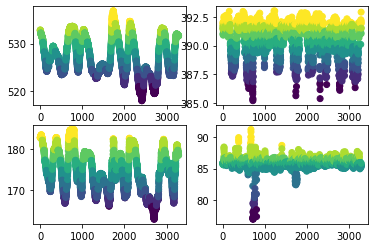

In [392]:
fig, ax = plt.subplots(2,2)
ax[0,0].scatter(y=data['Nivel 1'], x=range(data.shape[0]), c=data['Nivel 1_kmeans'])
ax[0,1].scatter(y=data['Nivel 2'], x=range(data.shape[0]), c=data['Nivel 2_kmeans'])
ax[1,0].scatter(y=data['Nivel 3'], x=range(data.shape[0]), c=data['Nivel 3_kmeans'])
ax[1,1].scatter(y=data['Nivel 4'], x=range(data.shape[0]), c=data['Nivel 4_kmeans'])
plt.show()


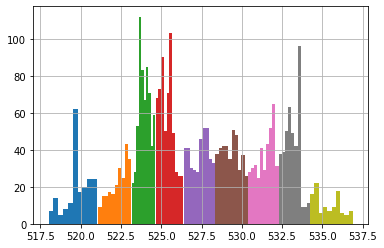

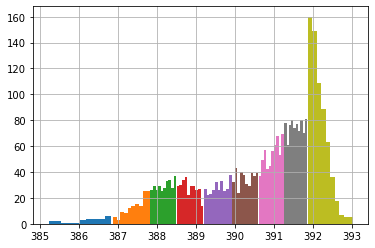

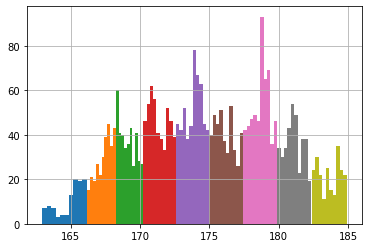

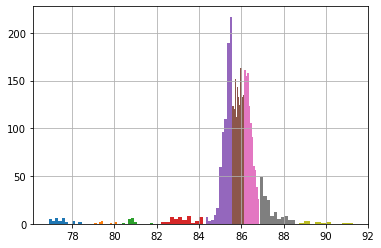

In [394]:
data.groupby('Nivel 1_kmeans')['Nivel 1'].hist()
plt.show()
data.groupby('Nivel 2_kmeans')['Nivel 2'].hist()
plt.show()
data.groupby('Nivel 3_kmeans')['Nivel 3'].hist()
plt.show()
data.groupby('Nivel 4_kmeans')['Nivel 4'].hist()
plt.show()

#### 7. Transformar  cada  variable  discretizada y compararla  con  la  original  mediante el histograma. ¿Hubo mejoría con respecto a la discretización por año?

In [338]:
for tanque in ['Nivel 1', 'Nivel 2', 'Nivel 3', 'Nivel 4']:
    x = np.array([])
    for group in data[tanque+'_kmeans'].unique():
        d = data.groupby(tanque+'_kmeans')[tanque].get_group(group).to_numpy()
        d = d - d.min() + 1
        bc, _ = boxcox(d)
        x = np.concatenate((x, bc))
    data[(tanque + '_kmeans_bc')] = x

array([[<AxesSubplot:title={'center':'Nivel 1_kmeans_bc'}>,
        <AxesSubplot:title={'center':'Nivel 2_kmeans_bc'}>],
       [<AxesSubplot:title={'center':'Nivel 3_kmeans_bc'}>,
        <AxesSubplot:title={'center':'Nivel 4_kmeans_bc'}>]], dtype=object)

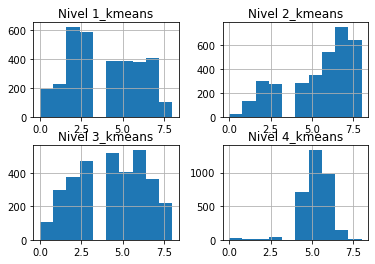

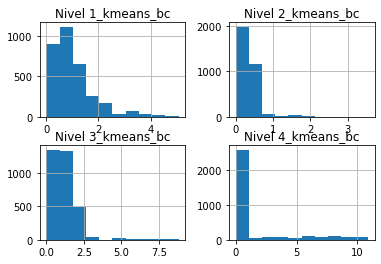

In [360]:
data[['Nivel 1_kmeans', 'Nivel 2_kmeans', 'Nivel 3_kmeans', 'Nivel 4_kmeans']].hist()
data[['Nivel 1_kmeans_bc', 'Nivel 2_kmeans_bc', 'Nivel 3_kmeans_bc', 'Nivel 4_kmeans_bc']].hist()

Para la discretización con **k means**, el histograma no parece normal, de hecho parece más uniforme que la original. El tanque 4, la que anteriormente se mostraba menos normal ahora se nota más normal. Para la discretización transformada parece ser que todas se desplazaron hacia la izquierda dando un sesgo positivo. El tanque 4 muestra algunos atípicos ya que todo queda concentrado entre el 0 y 1.

array([[<AxesSubplot:title={'center':'Nivel 1_years_bc'}>,
        <AxesSubplot:title={'center':'Nivel 2_years_bc'}>],
       [<AxesSubplot:title={'center':'Nivel 3_years_bc'}>,
        <AxesSubplot:title={'center':'Nivel 4_years_bc'}>]], dtype=object)

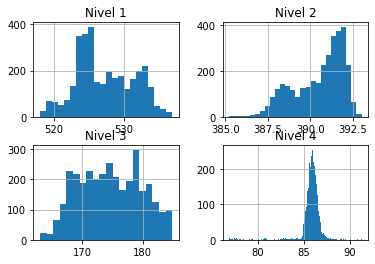

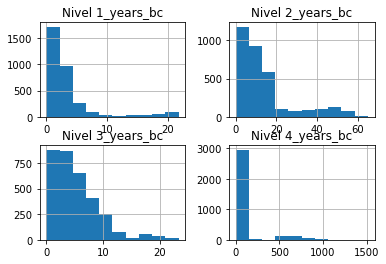

In [373]:
data[['Nivel 1', 'Nivel 2', 'Nivel 3', 'Nivel 4']].hist()
data[['Nivel 1_years_bc', 'Nivel 2_years_bc', 'Nivel 3_years_bc', 'Nivel 4_years_bc']].hist()

Sorpresivamente los histrogramas de la discretización por año y k means son muy similares. No hay una mejora visiblemente.